<a href="https://colab.research.google.com/github/Rajibsigdel12345/Vehicle-Detection/blob/main/Vehicle-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install opencv-python-headless ultralytics easyocr


In [392]:
import cv2
import numpy as np
from ultralytics import YOLO
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import easyocr

In [2]:
def lane_detection_image(image_path):

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blur_gray = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blur_gray, 50, 150)

    height, width = image.shape[:2]
    vertices = np.array([[(50, height), (width//2 - 30, height//2 + 50),
                          (width//2 + 30, height//2 + 50), (width-50, height)]], dtype=np.int32)
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180, threshold=15, minLineLength=40, maxLineGap=20)

    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

    combined = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [399]:

# Function to detect edges
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

# Function to define region of interest (ROI)
def region_of_interest(edges, vertices):
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)
    masked_edges = cv2.bitwise_and(edges, mask)
    return masked_edges

# Function to draw lane lines
def draw_lines(image, lines):
    if lines is None or len(lines) == 0:
        return image  # Return the original image if no lines are provided

    for line in lines:
        # Handle cases where lines are stored as nested or flat structures
        if isinstance(line, (list, np.ndarray)) and len(line) == 1:
            x1, y1, x2, y2 = line[0]  # Access the nested structure
        else:
            x1, y1, x2, y2 = line  # Directly unpack the coordinates

        # Draw the line on the image
        cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 5)

    return image

# Lane detection pipeline for a single image
def lane_detection_image(image_path):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    roi_vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)

    edges = detect_edges(image)
    roi_edges = region_of_interest(edges, roi_vertices)

    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=100, maxLineGap=50)
    image_with_lines = draw_lines(image.copy(), lines)

    plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return lines

# Run the lane detection on an image



In [4]:

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')  # Use a pretrained YOLOv8 model
def vehicle_detection_image(image_path):
    image = cv2.imread(image_path)
    results = model.predict(source=image, conf=0.5)

    detections = results[0].boxes.data.cpu().numpy()  # Get bounding box detections

    for detection in detections:
        x1, y1, x2, y2, conf, cls = map(int, detection)
        if cls == 2:  # Class ID 2 corresponds to 'car' in COCO
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, "Car", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
# Run the vehicle detection on an image



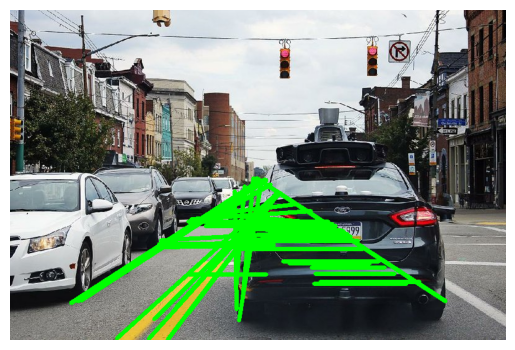

In [5]:
image_path = "resized_250499-ap16303000894530_73-23048_t800.jpg"  # Replace with your image path
lane_detection_image(image_path)


0: 448x640 4 cars, 3 traffic lights, 53.6ms
Speed: 6.0ms preprocess, 53.6ms inference, 167.2ms postprocess per image at shape (1, 3, 448, 640)


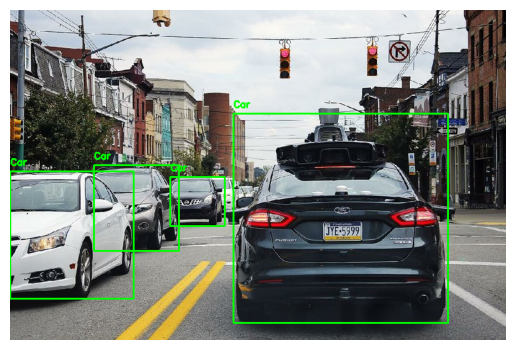

In [6]:
image_path = "resized_250499-ap16303000894530_73-23048_t800.jpg"  # Replace with your image path
vehicle_detection_image(image_path)

In [393]:
model = YOLO('yolov8n.pt')  # Use a YOLOv8 model, for example yolov8n.pt

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

In [ ]:



def detect_cars(image):
    # Perform detection with YOLOv8 model
    results = model(image)

    # Extract bounding boxes for cars
    bboxes = []
    for result in results[0].boxes:  # Iterate over detections (boxes are part of the result)
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  # Extract bbox coordinates
        conf = result.conf[0].cpu().numpy()  # Confidence score for the prediction
        class_id = result.cls[0].cpu().numpy()  # Class ID (for 'car' class ID should be 2)

        if class_id == 2 and conf>=0.6:  # Class ID 2 corresponds to 'car'
            bboxes.append([x1, y1, x2, y2, conf])

    return np.array(bboxes)


# Preprocess before passing to YOLO

def detect_plate_with_haar(image):
    plate_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plates = plate_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in plates:
        plate_region = image[y:y+h, x:x+w]
        return plate_region

    return None  # No plate detected


def detect_lanes(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 50, 150)

    mask = np.zeros_like(edges)
    height, width = edges.shape
    polygon = np.array([[
        (0, height),
        (width / 2, height / 2),
        (width, height)
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)

    masked_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(masked_edges, 0.4, np.pi / 360, threshold=10, minLineLength=100, maxLineGap=20)
    solid_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)

            
            # Solid lines are generally longer and have a specific angle
            if length > 100 and 40 < angle < 90:  # Adjust angle range as needed
                solid_lines.append((x1, y1, x2, y2))

    image_with_lines = draw_lines(image.copy(), solid_lines)
    plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    plt.title('Raw Lines Detected by Hough Transform')
    plt.show()
    return solid_lines

def filter_and_extrapolate_lines(lanes, min_length=150):
    """
    Filter out short lines and extrapolate the remaining lines symmetrically.

    Parameters:
        lanes (list): List of detected lanes [(x1, y1, x2, y2), ...].
        min_length (int): Minimum line length to consider.

    Returns:
        list: Filtered and adjusted lanes [(x1, y1, x2, y2), ...].
    """
    filtered_lanes = []
    for line in lanes:
        if isinstance(line, (list, np.ndarray)) and len(line) == 1:
            x1, y1, x2, y2 = line[0]
        else:
            x1, y1, x2, y2 = line
        length = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
        # Determine which point is higher and which is lower
        if y1 > y2:  # y1 is lower
            x_lower, y_lower, x_higher, y_higher = x1, y1, x2, y2
        else:  # y2 is lower
            x_lower, y_lower, x_higher, y_higher = x2, y2, x1, y1

        # Calculate the direction vector
        dx = x_higher - x_lower
        dy = y_higher - y_lower

        # Normalize the direction vector
        norm_factor = (dx ** 2 + dy ** 2) ** 0.5
        dx_normalized = dx / norm_factor
        dy_normalized = dy / norm_factor

        # Extend the line upwards
        x_higher_new = int(x_higher + dx_normalized * length*0.3)
        y_higher_new = int(y_higher + dy_normalized * length*0.3)


        filtered_lanes.append((x_lower, y_lower, x_higher_new, y_higher_new))

    return filtered_lanes


import math

def filter_lanes(lanes):
    """
    Filter detected lanes to remove false positives by checking if the lines are parallel
    and are close to each other. Lines that are too far apart will not be compared for parallelism.

    Parameters:
        lanes (list): List of lane lines [(x1, y1, x2, y2), ...].

    Returns:
        list: Filtered list of valid lane lines that are parallel to each other and close.
    """
    if not lanes or len(lanes) < 2:
        return lanes

    def calculate_angle(x1, y1, x2, y2):
        """Calculate the angle of a line in degrees."""
        return math.degrees(math.atan2(y2 - y1, x2 - x1))

    def calculate_distance(line1, line2):
        """Calculate the horizontal distance between two lines' x1 and x2 coordinates."""
        x1_1, _, x2_1, _ = line1
        x1_2, _, x2_2, _ = line2
        return min(abs(x1_1 - x1_2), abs(x2_1 - x2_2))

    filtered_lanes = []
    angles = []
    distance_threshold = 40  # Minimum horizontal distance between lines to compare their angles
    angle_threshold = 10  # Maximum angular difference for parallel lines

    # Calculate angles for all lines
    for line in lanes:
        x1, y1, x2, y2 = line
        angle = calculate_angle(x1, y1, x2, y2)
        angles.append((angle, line))

    # Group lines based on proximity and parallelism
    for i, (angle1, line1) in enumerate(angles):
        is_parallel = True
        for j, (angle2, line2) in enumerate(angles):
            if i != j:
                # print('i am here after loop')
                # Calculate horizontal distance between lines
                distance = calculate_distance(line1, line2)
                # # print(line1,line2,distance, "i am distance")
                # Only check parallelism if the lines are close enough
                if distance < distance_threshold:
                    if abs(angle1 - angle2) > angle_threshold:
                        is_parallel = False
                        break

        # If line1 is parallel to all nearby lines, add it to filtered_lanes
        if is_parallel:
            filtered_lanes.append(line1)

    # Remove duplicates
    unique_lanes = list({tuple(line) for line in filtered_lanes})

    return [list(line) for line in unique_lanes]

def track_and_crossing(image, car_bboxes, lanes, shrink_factor=1):
    """
    Check if car bounding boxes cross detected lanes with adjusted box size.

    Parameters:
        image (ndarray): Input image (BGR format).
        car_bboxes (list): List of car bounding boxes [(x1, y1, x2, y2), ...].
        lanes (list): List of lane lines [(x1, y1, x2, y2), ...].
        shrink_factor (float): Factor to shrink the bounding box (0 < shrink_factor <= 1).

    Returns:
        list: Bounding boxes of cars that crossed lanes.
    """
    width, height = image.shape[:2]
    lanes = filter_lanes(lanes)  # Filter zebra crossing lines
    lanes = filter_and_extrapolate_lines(lanes)  # Filter and extrapolate lanes
    # print(lanes, "i am lanes")
    image_with_lines = image.copy()
    image_with_lines = draw_lines(image_with_lines, lanes)  # Draw the detected lanes
    plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
    plt.title('Detected Lanes with extrapolation and removing unwanted lines')
    plt.show()
    bboxes = []
    if lanes is None or len(lanes) == 0:
        return bboxes

    def line_intersects(line1, line2):
        """Check if two line segments (line1 and line2) intersect."""
        def ccw(A, B, C):
            """Helper function to check counter-clockwise order."""
            return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

        A, B = line1
        C, D = line2
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

    for bbox in car_bboxes:
        x1, y1, x2, y2, _ = map(int, bbox)
        
        # Shrink the bounding box
        width = x2 - x1
        height = y2 - y1
        shrink_x = int(width * (1 - shrink_factor) / 2)
        shrink_y = int(height * (1 - shrink_factor) / 2)

        x1_shrink = x1 + shrink_x
        y1_shrink = y1 + shrink_y
        x2_shrink = x2 - shrink_x
        y2_shrink = y2 - shrink_y

        # Represent the shrunken bounding box as four line segments
        car_lines = [
            ((x1_shrink, y1_shrink), (x2_shrink, y1_shrink)),  # Top
            ((x2_shrink, y1_shrink), (x2_shrink, y2_shrink)),  # Right
            ((x2_shrink, y2_shrink), (x1_shrink, y2_shrink)),  # Bottom
            ((x1_shrink, y2_shrink), (x1_shrink, y1_shrink)),  # Left
        ]

        for lane in lanes:
            # print(bbox,lane, "i am lane and bobx")
            if isinstance(lane, (list, np.ndarray)) and len(lane) == 1:
                x1_line, y1_line, x2_line, y2_line = lane[0]
            else:
                x1_line, y1_line, x2_line, y2_line = lane

            lane_line = ((x1_line, y1_line), (x2_line, y2_line))

            # Check for intersection with any side of the shrunken bounding box
            if any(line_intersects(car_line, lane_line) for car_line in car_lines):
                # print(f"Car crossed lane at bounding box: {bbox}")
                bboxes.append(bbox)
                # Draw the car bounding box and the lane
                cv2.rectangle(image, (x1_shrink, y1_shrink), (x2_shrink, y2_shrink), (255, 0, 0), 2)
                cv2.line(image, (x1_line, y1_line), (x2_line, y2_line), (0, 0, 255), 2)
                break  # No need to check other lanes for this car

    # Display the result
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Cars Crossing Lanes')
    plt.show()

    return bboxes




def extract_number_plate(image, car_bbox= None):
  number_plate = []
  for plate_roi in image:
    plt.imshow(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Number Plate')
    plt.show()
    # print(plate_roi)
    result = reader.readtext(plate_roi)
    threshold_conf = 0.1
    max_conf = 0
    for detection in result:
        _, text, confidence = detection
        # print(confidence, "iam confident")
        if confidence > threshold_conf and confidence > max_conf:
          number_plate.append(text)
  return number_plate

# Load the image and run the detection pipeline

def preprocess_number_plate(image, car_bbox):
    # Crop the number plate area
  processed_plates = []
  hash_map = {}
  for bbox in car_bbox:
    x1, y1, x2, y2 = map(int, bbox[:4])
    if not (x1, y1, x2, y2) in hash_map:
        plate_region = image[y1:y2, x1:x2]
        plate_region = detect_plate_with_haar(plate_region)
        # print(plate_region, "i am plate region")
        if plate_region is not None:
            processed_plates.append(plate_region)
            hash_map[(x1, y1, x2, y2)] = 1
  # print(processed_plates,len(processed_plates), 'iam plates')
  # print(hash_map, "i am hash")
  return processed_plates




0: 480x640 2 cars, 2 trucks, 1 traffic light, 84.0ms
Speed: 23.0ms preprocess, 84.0ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)


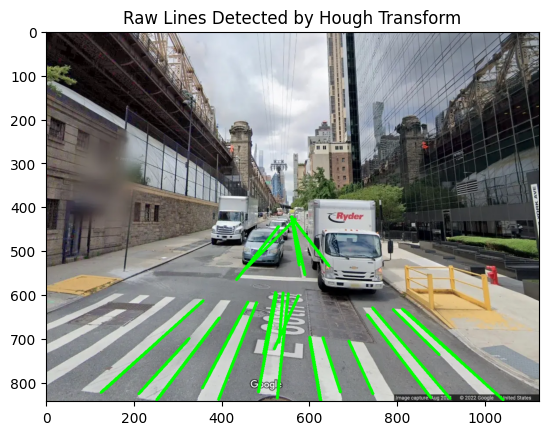

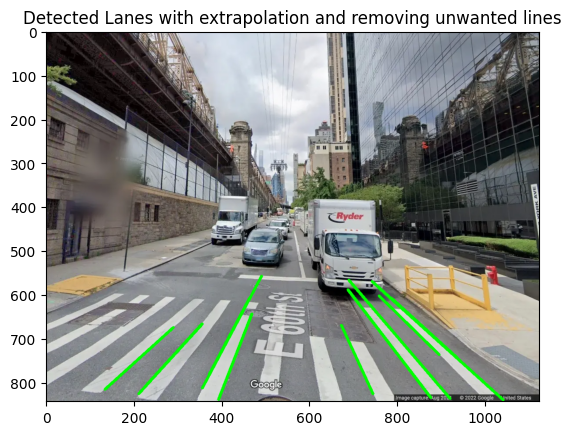

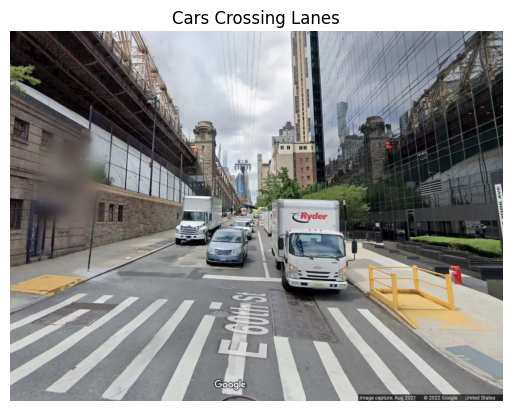

No number plate detected


In [443]:
image = cv2.imread("upper-east-side-60th-street-bike-lane-protected-concrete-eric-adams___25122323220.webp")

car_bboxes = detect_cars(image)
# print(car_bboxes.shape, "here at ")
lanes = detect_lanes(image)
# image = preprocess_image(image)
tracked_car = track_and_crossing(image, car_bboxes, lanes)

# Extract number plate for the first detected car
preprocessed_image = preprocess_number_plate(image, tracked_car)
if preprocessed_image:
  number_plate = extract_number_plate(preprocessed_image)
  print(f"Detected Number Plate: {number_plate}")
else:
  print("No number plate detected")
# Show the final image with lanes and car detection
plt.show()